# 查看FashionMNIST原始数据格式

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model as evaluate_model


In [3]:
import json
token = {"username":"huangdongsheng123","key":"bc7074d3e7a23aa7233f350712ff381d"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!cat /content/kaggle.json

{"username": "huangdongsheng123", "key": "bc7074d3e7a23aa7233f350712ff381d"}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [6]:
!kaggle competitions download -c cifar-10

 98% 700M/715M [00:03<00:00, 182MB/s]
100% 715M/715M [00:03<00:00, 201MB/s]


In [7]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [8]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 30.9 MB/s eta 0:00:00


In [9]:
!ls competitions/cifar-10/train|wc -l

50000


# 加载数据并处理为tensor

In [10]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

# 加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"
# img_dir = r"D:\cifar-10\train\train"
# labels_file = r"D:\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [11]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
# cal_mean_std(train_dataset)

# 把数据集划分为训练集45000和验证集5000，并给DataLoader

In [12]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)




# 搭建模型

In [13]:
#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100)
x=torch.randn(20,100)
print(m(x).shape)

torch.Size([20, 100])


# 搭建模型

In [14]:
# 定义残差块类
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # 第一个卷积层
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 第二个卷积层
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 如果输入和输出通道数不同或步长不为1，则需要使用1x1卷积进行调整
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual) # 残差连接
        out = self.relu(out)

        return out

# 定义ResNet18模型
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # 初始卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 残差层
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2) #分别代表输入通道数，输出通道数，残差块数量，步长
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # 全局平均池化和全连接层
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """
        创建一个残差层
        :param in_channels: 输入通道数
        :param out_channels: 输出通道数
        :param num_blocks: 残差块数量
        :param stride: 步长
        :return: 残差层
        """
        layers = []
        # 第一个残差块可能需要调整通道数和特征图大小
        layers.append(ResidualBlock(in_channels, out_channels, stride))

        # 后续残差块的输入通道数已经是out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers) #*解包

    def forward(self, x):
        # print(f"输入形状: {x.shape}")

        x = self.conv1(x)
        # print(f"conv1后形状: {x.shape}")
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        # print(f"layer1后形状: {x.shape}")
        x = self.layer2(x) #输出shape是[1, 128, 16, 16]
        # print(f"layer2后形状: {x.shape}")
        x = self.layer3(x) #输出shape是[1, 256, 8, 8]
        # print(f"layer3后形状: {x.shape}")
        x = self.layer4(x) #输出shape是[1, 512, 4, 4]
        # print(f"layer4后形状: {x.shape}")

        x = self.avgpool(x)
        # print(f"avgpool后形状: {x.shape}")
        x = torch.flatten(x, 1)
        # print(f"flatten后形状: {x.shape}")
        x = self.fc(x)
        # print(f"fc后形状: {x.shape}")

        return x


In [15]:
# 实例化模型
model = ResNet18()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [16]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 11173962
模型总参数量: 11173962

各层参数量明细:
conv1.weight: 1728 参数
bn1.weight: 64 参数
bn1.bias: 64 参数
layer1.0.conv1.weight: 36864 参数
layer1.0.bn1.weight: 64 参数
layer1.0.bn1.bias: 64 参数
layer1.0.conv2.weight: 36864 参数
layer1.0.bn2.weight: 64 参数
layer1.0.bn2.bias: 64 参数
layer1.1.conv1.weight: 36864 参数
layer1.1.bn1.weight: 64 参数
layer1.1.bn1.bias: 64 参数
layer1.1.conv2.weight: 36864 参数
layer1.1.bn2.weight: 64 参数
layer1.1.bn2.bias: 64 参数
layer2.0.conv1.weight: 73728 参数
layer2.0.bn1.weight: 128 参数
layer2.0.bn1.bias: 128 参数
layer2.0.conv2.weight: 147456 参数
layer2.0.bn2.weight: 128 参数
layer2.0.bn2.bias: 128 参数
layer2.0.shortcut.0.weight: 8192 参数
layer2.0.shortcut.1.weight: 128 参数
layer2.0.shortcut.1.bias: 128 参数
layer2.1.conv1.weight: 147456 参数
layer2.1.bn1.weight: 128 参数
layer2.1.bn1.bias: 128 参数
layer2.1.conv2.weight: 147456 参数
layer2.1.bn2.weight: 128 参数
layer2.1.bn2.bias: 128 参数
layer3.0.conv1.weight: 294912 参数
layer3.0.bn1.weight: 256 参数
layer3.0.bn1.bias: 256 参数
layer3.0.conv2.weight:

In [17]:
128*3*3*256

294912

# 各层参数量明细:
conv1.weight: 288 参数 3*3*1*32
conv1.bias: 32 参数
conv2.weight: 9216 参数 3*3*32*32
conv2.bias: 32 参数  
conv3.weight: 18432 参数 3*3*32*64
conv3.bias: 64 参数
conv4.weight: 36864 参数  3*3*64*64
conv4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
fc1.weight: 294912 参数 128*3*3*256
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数

In [18]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0480, -0.1329, -0.1446],
                        [-0.1062, -0.0521, -0.0070],
                        [ 0.1015,  0.0487,  0.1454]],
              
                       [[ 0.0042,  0.0565,  0.1594],
                        [-0.1113,  0.0308, -0.1157],
                        [-0.0658,  0.1643, -0.1302]],
              
                       [[ 0.0294, -0.1100, -0.1080],
                        [ 0.1792,  0.0878, -0.1116],
                        [-0.0679, -0.1509,  0.0304]]],
              
              
                      [[[-0.1734, -0.0474, -0.0172],
                        [-0.0737, -0.0488, -0.1670],
                        [-0.0053, -0.0789,  0.1103]],
              
                       [[ 0.0096, -0.1803, -0.1860],
                        [ 0.0683,  0.0084, -0.1650],
                        [ 0.1315,  0.0405, -0.1736]],
              
                       [[-0.0217, -0.0089,  0.0896],
                        [-

# 设置交叉熵损失函数，SGD优化器

In [19]:
model = ResNet18()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)



损失函数: CrossEntropyLoss()


In [20]:
model = ResNet18()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0
训练开始，共35200步


  0%|          | 0/35200 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): 79.9600
早停: 在15000 步


In [22]:
history['train'][-100:-1]

[{'loss': 0.006528753321617842, 'acc': 100.0, 'step': 14901},
 {'loss': 0.0017200675792992115, 'acc': 100.0, 'step': 14902},
 {'loss': 0.004684143699705601, 'acc': 100.0, 'step': 14903},
 {'loss': 0.005328361876308918, 'acc': 100.0, 'step': 14904},
 {'loss': 0.008093906566500664, 'acc': 100.0, 'step': 14905},
 {'loss': 0.003605063771829009, 'acc': 100.0, 'step': 14906},
 {'loss': 0.011311437003314495, 'acc': 100.0, 'step': 14907},
 {'loss': 0.0217851921916008, 'acc': 98.4375, 'step': 14908},
 {'loss': 0.029721856117248535, 'acc': 98.4375, 'step': 14909},
 {'loss': 0.003805955173447728, 'acc': 100.0, 'step': 14910},
 {'loss': 0.0037307182792574167, 'acc': 100.0, 'step': 14911},
 {'loss': 0.004188719671219587, 'acc': 100.0, 'step': 14912},
 {'loss': 0.0006343567511066794, 'acc': 100.0, 'step': 14913},
 {'loss': 0.006420183461159468, 'acc': 100.0, 'step': 14914},
 {'loss': 0.010432213544845581, 'acc': 100.0, 'step': 14915},
 {'loss': 0.00965319573879242, 'acc': 100.0, 'step': 14916},
 {'l

In [23]:
history['val'][-1000:-1]

[{'loss': 2.3027986267089844, 'acc': 10.26, 'step': 0},
 {'loss': 1.3170644485473633, 'acc': 53.06, 'step': 500},
 {'loss': 1.1968577402114868, 'acc': 59.68, 'step': 1000},
 {'loss': 0.8019061044692993, 'acc': 71.94, 'step': 1500},
 {'loss': 0.804770965051651, 'acc': 71.96, 'step': 2000},
 {'loss': 0.9326461839675904, 'acc': 69.8, 'step': 2500},
 {'loss': 0.7618093583583831, 'acc': 74.5, 'step': 3000},
 {'loss': 0.8468711791992187, 'acc': 72.28, 'step': 3500},
 {'loss': 0.8860932344913482, 'acc': 74.34, 'step': 4000},
 {'loss': 0.8410357930660248, 'acc': 76.34, 'step': 4500},
 {'loss': 0.8777863676786423, 'acc': 75.92, 'step': 5000},
 {'loss': 0.9379492696762085, 'acc': 74.88, 'step': 5500},
 {'loss': 0.8654316294670105, 'acc': 76.98, 'step': 6000},
 {'loss': 0.8739719573974609, 'acc': 77.4, 'step': 6500},
 {'loss': 0.9492776950836181, 'acc': 76.38, 'step': 7000},
 {'loss': 0.8336828990936279, 'acc': 79.36, 'step': 7500},
 {'loss': 0.8484703531265259, 'acc': 78.84, 'step': 8000},
 {'lo

# 绘制损失曲线和准确率曲线

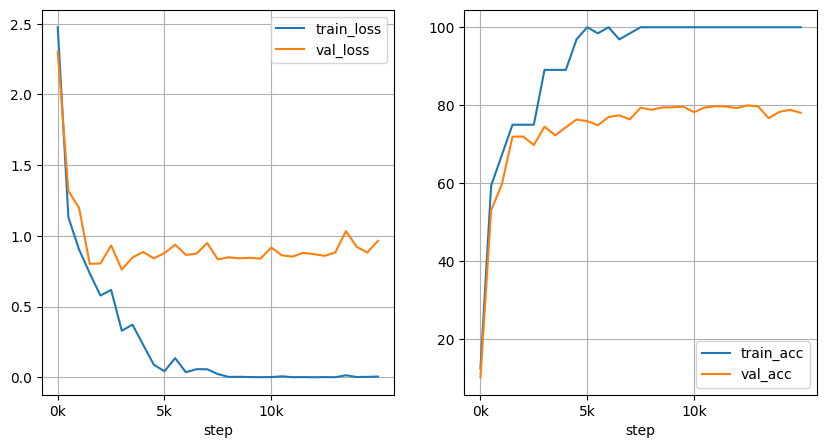

In [24]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [25]:
a =py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [26]:
!ls competitions/cifar-10/test|wc -l

300000


In [27]:
!ls

competitions   sample_data	     trainLabels.csv
kaggle.json    sampleSubmission.csv  wangdao_deeplearning_train.py
model_weights  test.7z
__pycache__    train.7z


In [31]:
# 导入所需库
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm

# 定义测试数据集类
class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        初始化测试数据集

        参数:
            img_dir: 测试图片目录
            transform: 图像预处理变换
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 提取图像ID（文件名去掉扩展名）
        img_id = int(os.path.splitext(self.img_files[idx])[0])

        return image, img_id

# 定义预测函数
def predict_test_set(model, img_dir, labels_file, device, batch_size=64):
    """
    预测测试集并生成提交文件

    参数:
        model: 训练好的模型
        img_dir: 测试图片目录
        labels_file: 提交模板文件路径
        device: 计算设备
        batch_size: 批处理大小
    """
    # 图像预处理变换（与训练集相同）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
    ])

    # 创建测试数据集和数据加载器
    test_dataset = CIFAR10TestDataset(img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # 设置模型为评估模式
    model.eval()

    # 读取提交模板
    submission_df = pd.read_csv(labels_file)
    predictions = {}

    # 使用tqdm显示进度条
    print("正在预测测试集...")
    with torch.no_grad():
        for images, img_ids in tqdm.tqdm(test_loader, desc="预测进度"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #取最大的索引，作为预测结果

            # 记录每个图像的预测结果
            for i, img_id in enumerate(img_ids):
                predictions[img_id.item()] = predicted[i].item() #因为一个批次有多个图像，所以需要predicted[i]

    # 定义类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # 将数值标签转换为类别名称
    labeled_predictions = {img_id: class_names[pred] for img_id, pred in predictions.items()}

    # 直接创建DataFrame
    submission_df = pd.DataFrame({
        'id': list(labeled_predictions.keys()),
        'label': list(labeled_predictions.values())
    })
    # 按id列排序
    submission_df = submission_df.sort_values(by='id')

    # 检查id列是否有重复值
    has_duplicates = submission_df['id'].duplicated().any()
    print(f"id列是否有重复值: {has_duplicates}")
    # 保存预测结果
    output_file = 'cifar10_submission.csv'
    submission_df.to_csv(output_file, index=False)
    print(f"预测完成，结果已保存至 {output_file}")

# 执行测试集预测
img_dir = r"competitions/cifar-10/test"
labels_file = r"./sampleSubmission.csv"
predict_test_set(model, img_dir, labels_file, device, batch_size=128)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


正在预测测试集...


预测进度:   0%|          | 0/2344 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
预测进度: 100%|██████████| 2344/2344 [02:22<00:00, 16.44it/s]


id列是否有重复值: False
预测完成，结果已保存至 cifar10_submission.csv


In [29]:
!head -10 cifar10_submission.csv

In [30]:
!wc -l cifar10_submission.csv